In [ ]:
# Import all relevant libraries
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Iteration 1/200
Sampled Hyperparameters:  {'n_estimators': 156, 'learning_rate': 0.0960924571078925, 'max_depth': 8, 'max_features': 8}
Mean Score: 0.9367485624673288
Iteration 2/200
Sampled Hyperparameters:  {'n_estimators': 58, 'learning_rate': 0.04231149990417569, 'max_depth': 14, 'max_features': 35}
Mean Score: 0.9357030841610037
Iteration 3/200
Sampled Hyperparameters:  {'n_estimators': 151, 'learning_rate': 0.02857446350571588, 'max_depth': 11, 'max_features': 3}
Mean Score: 0.9304756926293779
Iteration 4/200
Sampled Hyperparameters:  {'n_estimators': 80, 'learning_rate': 0.06444102495066024, 'max_depth': 6, 'max_features': 22}
Mean Score: 0.9346576058546785
Iteration 5/200
Sampled Hyperparameters:  {'n_estimators': 122, 'learning_rate': 0.06038534241912373, 'max_depth': 6, 'max_features': 40}
Mean Score: 0.9362258233141663
Iteration 6/200
Sampled Hyperparameters:  {'n_estimators': 91, 'learning_rate': 0.017407452795206193, 'max_depth': 14, 'max_features': 37}
Mean Score: 0.93152

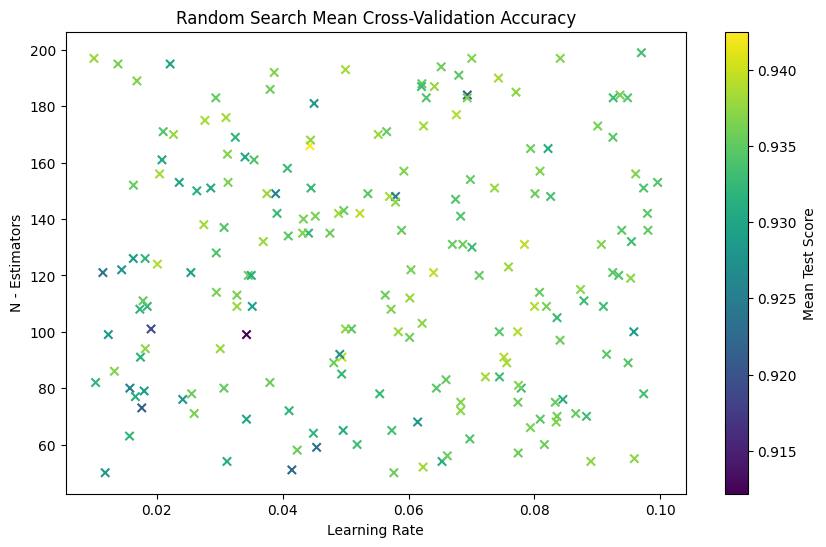

In [ ]:

# Initialize an empty DataFrame to store the results of each iteration
results_history = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'max_features', 'mean_test_score'])

# Load the dataset
file_path = "/content/drive/My Drive/imputed_dataset.csv"
try:
    pima = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError("CSV file not found at the specified path.")

# Verify if pima is a DataFrame
if not isinstance(pima, pd.DataFrame):
    raise ValueError("The dataset is not loaded into a DataFrame.")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(pima['koi_disposition'])

pima_numeric = pima.dropna(subset=['koi_score'])

# Save the 'koi_disposition' column separately before dropping it from pima_numeric
koi_disposition_column = pima['koi_disposition']

non_numeric_columns = pima.select_dtypes(exclude=['number']).columns

# Drop 'koi_disposition' and any other non-numeric columns
pima_numeric = pima.drop(columns=non_numeric_columns)

pima_numeric['koi_disposition'] = koi_disposition_column

# Split dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(pima_numeric.drop('koi_disposition', axis=1),
                                                    y, test_size=0.2)

# Step 5: Handle missing values using SimpleImputer for X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 6: Scale the data
scaler = StandardScaler().fit(X_train_imputed)
X_train_transformed = scaler.transform(X_train_imputed)
X_test_transformed = scaler.transform(X_test_imputed)

# Set initial ranges for each hyperparameter
param_ranges = {
    'n_estimators': (90, 130),
    'learning_rate': (0.01, 0.1),
    'max_depth': (5, 15),
    'max_features': ['sqrt', 'log2', None]
}

# Set the number of iterations for random search
num_iterations = 200

# Initialize an empty DataFrame to store the results of each iteration
results_history = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'max_features', 'mean_test_score'])

# Perform multiple iterations of the hyperparameter search
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Sample new values for each parameter from the specified ranges
    sampled_params = {
        'n_estimators': np.random.randint(50, 200),
        'learning_rate': np.random.uniform(0.01, 0.1),
        'max_depth': np.random.randint(5, 15),
        'max_features': np.random.randint(1, len(pima_numeric.columns) + 1)
    }

    print("Sampled Hyperparameters: ", sampled_params)  # Print the sampled hyperparameters

    # Create the GradientBoostingClassifier with the sampled parameters
    gbc = GradientBoostingClassifier(n_estimators=sampled_params['n_estimators'],
                                     learning_rate=sampled_params['learning_rate'],
                                     max_depth=sampled_params['max_depth'],
                                     max_features=sampled_params['max_features'],
                                     random_state=100)

    # Perform the cross-validation on the training data
    #cv_scores = cross_val_score(gbc, X_train_transformed, y_train, cv=5)

    # Calculate the mean cross-validation score
    #mean_cv_score = np.mean(cv_scores)

    # Fit the classifier to the training data
    gbc.fit(X_train_transformed, y_train)

    # Get the feature importances
    feature_importances = gbc.feature_importances_

    # Sort the features based on their importances
    sorted_features = np.argsort(feature_importances)[::-1]

    # Select the top k features (you can choose a value for k based on your preference)
    k = 10
    selected_features = X_train.columns[sorted_features[:k]]

    # Use only the selected features for training and testing
    X_train_selected = X_train_transformed[:, sorted_features[:k]]
    X_test_selected = X_test_transformed[:, sorted_features[:k]]


    # Evaluate the classifier on the test data
    mean_cv_score = gbc.score(X_test_transformed, y_test)

    print("Mean Score: " + str(mean_cv_score))

    # Save the results of this iteration in the results_history DataFrame
    iteration_results = {'n_estimators': sampled_params['n_estimators'],
                         'learning_rate': sampled_params['learning_rate'],
                         'max_depth': sampled_params['max_depth'],
                         'max_features': sampled_params['max_features'],
                         'mean_test_score': mean_cv_score}

    results_history = results_history.append(iteration_results, ignore_index=True)

# Display the results history
print(results_history)

# Visualize the results history
plt.figure(figsize=(10, 6))
plt.scatter(results_history['learning_rate'], results_history['n_estimators'], c=results_history['mean_test_score'], cmap='viridis', marker='x')
plt.xlabel('Learning Rate')
plt.ylabel('N - Estimators')
plt.title('Random Search Mean Cross-Validation Accuracy')
plt.colorbar(label='Mean Test Score')
plt.show()



In [ ]:
# Create the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Train the model
gbr.fit(X_train_transformed, y_train)

# Predict the scores on the test set
y_pred = gbr.predict(X_test_transformed)

# Evaluate the model (you can use different metrics as needed)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

# Visualize the predictions vs. true values (optional)
plt.scatter(y_test, y_pred)
plt.xlabel('True koi_score')
plt.ylabel('Predicted koi_score')
plt.title('Regression Tree Predictions')
plt.show()